## Практическое задание

Вариант 1. (простой)

- обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на датасете fashion-mnist или cifar10
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, Dropout, Flatten, Dense, BatchNormalization, MaxPool2D, Activation, MaxPooling2D
from tensorflow.keras import optimizers

from typing import List, Tuple

# устраняем проблему с загрузкой cifar10 (certificate verify failed: certificate has expired (_ssl.c:1123))
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# функция для вычисления доверительного интервала
def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [3]:
# Количество классов изображений
nb_classes = 10
# Названия классов из набора данных CIFAR-10
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

train_images, train_labels = x_train[:5000], y_train[:5000]
test_images, test_labels = x_test[:5000], y_test[:5000]

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

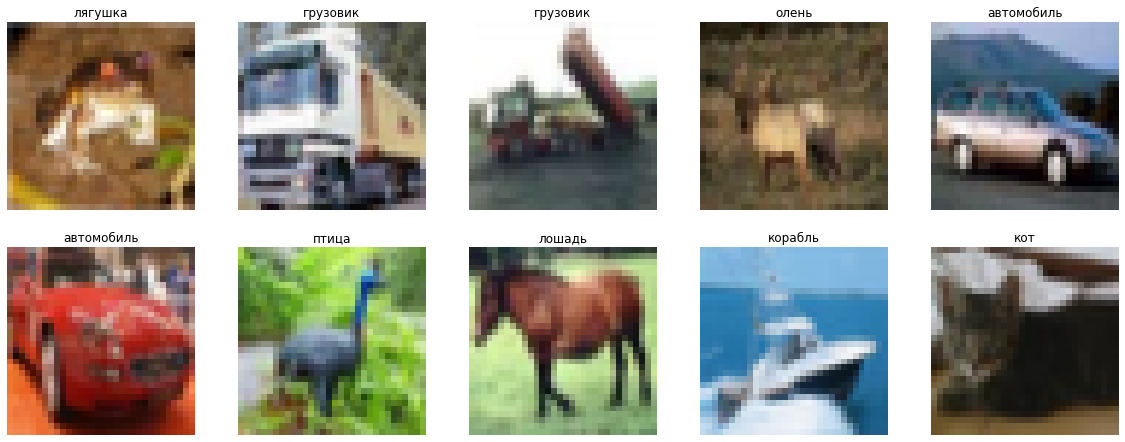

In [4]:
plt.figure(figsize=(20,20))
for i, (image, label) in enumerate(train_ds.take(10)):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(classes[label.numpy()[0]])
    plt.axis('off')

In [5]:
def process_images(image, label):
    # нормализуем изображение
    image = tf.image.per_image_standardization(image)
    # меняем размер картинки с 32x32 на 277x277
    image = tf.image.resize(image, (227,227))
    return image, label

In [6]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)

Training data size: 5000
Test data size: 5000


In [7]:
train_ds = (train_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

###### Базовая модель 3 слоя количество нейронов в каждом слое 32

In [8]:
# базавая модель с которой будем производить дальнейшие манипуляции

model = Sequential([
    Conv2D(filters=32, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

In [9]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 32)        11648     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9

In [10]:
summary_data = pd.DataFrame(columns=['layers', 'neurons', 'val_accuracy'])

hist = model.fit(train_ds, epochs=10, validation_data=test_ds, validation_freq=1)

test_loss, test_metric = model.evaluate(test_ds)

summary_data.loc["Базовая модель", ['layers', 'neurons', 'val_accuracy']] = [3, 32, test_metric]
summary_data

Epoch 1/10
156/156 [==============================] - 37s 228ms/step - loss: 2.8510 - accuracy: 0.1897 - val_loss: 1.9442 - val_accuracy: 0.3117
Epoch 2/10
156/156 [==============================] - 35s 222ms/step - loss: 2.2947 - accuracy: 0.2784 - val_loss: 1.7795 - val_accuracy: 0.3704
Epoch 3/10
156/156 [==============================] - 35s 221ms/step - loss: 2.0274 - accuracy: 0.3484 - val_loss: 1.6953 - val_accuracy: 0.4131
Epoch 4/10
156/156 [==============================] - 35s 221ms/step - loss: 1.8645 - accuracy: 0.3766 - val_loss: 1.6571 - val_accuracy: 0.4291
Epoch 5/10
156/156 [==============================] - 35s 223ms/step - loss: 1.7578 - accuracy: 0.4091 - val_loss: 1.6202 - val_accuracy: 0.4363
Epoch 6/10
156/156 [==============================] - 36s 225ms/step - loss: 1.6527 - accuracy: 0.4383 - val_loss: 1.5576 - val_accuracy: 0.4571
Epoch 7/10
156/156 [==============================] - 35s 223ms/step - loss: 1.5650 - accuracy: 0.4571 - val_loss: 1.5329 - val_ac

,layers,neurons,val_accuracy
Базовая модель,3,32,0.489784


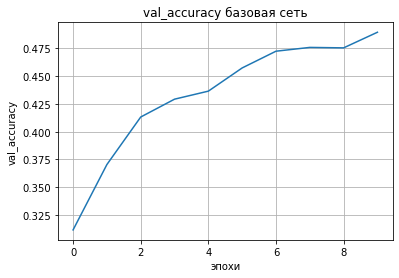

In [11]:
plt.plot(np.arange(10), hist.history['val_accuracy'])
plt.title('val_accuracy базовая сеть', fontsize=12)
plt.ylabel('val_accuracy')
plt.xlabel('эпохи')
plt.grid(True)
plt.show()

###### Оценим рост точности при увеличении ширины сети (больше ядер)

###### Модель 3 слоя количество нейронов в каждом слое 64.

In [12]:
model = Sequential([
    Conv2D(filters=64, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

In [13]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])

In [14]:
hist = model.fit(train_ds, epochs=10, validation_data=test_ds, validation_freq=1)

test_loss, test_metric = model.evaluate(test_ds)

summary_data.loc["Модель больше нейронов", ['layers', 'neurons', 'val_accuracy']] = [3, 64, test_metric]
summary_data

Epoch 1/10
156/156 [==============================] - 64s 406ms/step - loss: 2.6917 - accuracy: 0.2242 - val_loss: 1.9964 - val_accuracy: 0.2857
Epoch 2/10
156/156 [==============================] - 63s 397ms/step - loss: 2.0457 - accuracy: 0.3383 - val_loss: 1.6971 - val_accuracy: 0.4052
Epoch 3/10
156/156 [==============================] - 62s 395ms/step - loss: 1.7735 - accuracy: 0.4181 - val_loss: 1.6430 - val_accuracy: 0.4365
Epoch 4/10
156/156 [==============================] - 63s 397ms/step - loss: 1.6146 - accuracy: 0.4571 - val_loss: 1.5674 - val_accuracy: 0.4621
Epoch 5/10
156/156 [==============================] - 63s 400ms/step - loss: 1.4742 - accuracy: 0.4960 - val_loss: 1.5521 - val_accuracy: 0.4663
Epoch 6/10
156/156 [==============================] - 63s 401ms/step - loss: 1.3843 - accuracy: 0.5206 - val_loss: 1.5150 - val_accuracy: 0.4834
Epoch 7/10
156/156 [==============================] - 63s 401ms/step - loss: 1.2702 - accuracy: 0.5559 - val_loss: 1.4970 - val_ac

,layers,neurons,val_accuracy
Базовая модель,3,32,0.489784
Модель больше нейронов,3,64,0.508213


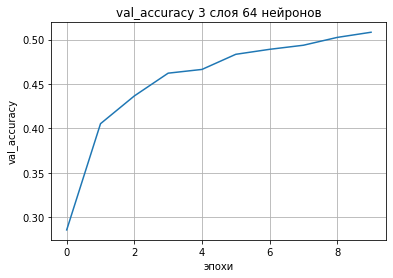

In [15]:
plt.plot(np.arange(10), hist.history['val_accuracy'])
plt.title('val_accuracy 3 слоя 64 нейронов', fontsize=12)
plt.ylabel('val_accuracy')
plt.xlabel('эпохи')
plt.grid(True)
plt.show()

Лучший результат - val_accuracy = 0.5082 это лучше чем у базовой модели (0.4898).
###### Вывод: 
С увеличением ширины сети точночть модели растёт.

###### Оценим рост точности (по сравнению с базовой) при увеличении глубины сети (больше слоев)¶
###### Модель 5 слоев количество нейронов в каждом слое 32.

In [16]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),

    # добавим два слоя       
    Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
           
    Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

In [17]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])

In [18]:
hist = model.fit(train_ds, epochs=10, validation_data=test_ds, validation_freq=1)

test_loss, test_metric = model.evaluate(test_ds)

summary_data.loc["Модель больше слоев", ['layers', 'neurons', 'val_accuracy']] = [5, 32, test_metric]
summary_data

Epoch 1/10
156/156 [==============================] - 37s 229ms/step - loss: 3.1365 - accuracy: 0.1450 - val_loss: 2.2470 - val_accuracy: 0.1647
Epoch 2/10
156/156 [==============================] - 36s 226ms/step - loss: 2.5685 - accuracy: 0.2021 - val_loss: 2.1138 - val_accuracy: 0.2276
Epoch 3/10
156/156 [==============================] - 36s 223ms/step - loss: 2.3173 - accuracy: 0.2340 - val_loss: 1.9269 - val_accuracy: 0.3123
Epoch 4/10
156/156 [==============================] - 36s 224ms/step - loss: 2.2078 - accuracy: 0.2470 - val_loss: 1.8748 - val_accuracy: 0.3337
Epoch 5/10
156/156 [==============================] - 36s 224ms/step - loss: 2.0983 - accuracy: 0.2819 - val_loss: 1.7975 - val_accuracy: 0.3540
Epoch 6/10
156/156 [==============================] - 36s 224ms/step - loss: 2.0110 - accuracy: 0.3017 - val_loss: 1.7677 - val_accuracy: 0.3610
Epoch 7/10
156/156 [==============================] - 36s 224ms/step - loss: 1.9329 - accuracy: 0.3145 - val_loss: 1.7499 - val_ac

,layers,neurons,val_accuracy
Базовая модель,3,32,0.489784
Модель больше нейронов,3,64,0.508213
Модель больше слоев,5,32,0.39984


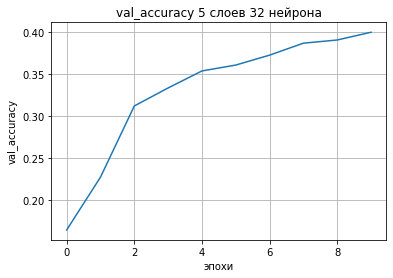

In [19]:
plt.plot(np.arange(10), hist.history['val_accuracy'])
plt.title('val_accuracy 5 слоев 32 нейрона', fontsize=12)
plt.ylabel('val_accuracy')
plt.xlabel('эпохи')
plt.grid(True)
plt.show()

Лучший результат - val_accuracy = 0.3998 это хуже чем у базовой модели (0.4898).
###### Вывод: 
С увеличением глубины сети точночть модели уменьшилось, т.е. с увеличением количества числа слоёв точность как минимум не всегда растёт.

### *(опционально) сравнить с точностью полносвязной сети для этой выборки

In [20]:
model = Sequential([
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])

hist = model.fit(train_ds, epochs=10, validation_data=test_ds, validation_freq=1)

test_loss, test_metric = model.evaluate(test_ds)

summary_data.loc["Полносвязная сеть", ['layers', 'neurons', 'val_accuracy']] = [0, 0, test_metric]
summary_data

Epoch 1/10
156/156 [==============================] - 39s 243ms/step - loss: 3.1908 - accuracy: 0.2606 - val_loss: 2.3708 - val_accuracy: 0.3532
Epoch 2/10
156/156 [==============================] - 38s 240ms/step - loss: 2.6056 - accuracy: 0.3496 - val_loss: 2.2362 - val_accuracy: 0.3590
Epoch 3/10
156/156 [==============================] - 38s 240ms/step - loss: 2.3135 - accuracy: 0.3948 - val_loss: 2.2274 - val_accuracy: 0.3954
Epoch 4/10
156/156 [==============================] - 38s 240ms/step - loss: 2.1022 - accuracy: 0.4389 - val_loss: 2.2197 - val_accuracy: 0.3770
Epoch 5/10
156/156 [==============================] - 38s 241ms/step - loss: 1.8360 - accuracy: 0.4890 - val_loss: 2.2045 - val_accuracy: 0.4012
Epoch 6/10
156/156 [==============================] - 38s 241ms/step - loss: 1.6948 - accuracy: 0.5188 - val_loss: 2.1575 - val_accuracy: 0.3956
Epoch 7/10
156/156 [==============================] - 38s 242ms/step - loss: 1.6026 - accuracy: 0.5312 - val_loss: 2.2033 - val_ac

,layers,neurons,val_accuracy
Базовая модель,3,32,0.489784
Модель больше нейронов,3,64,0.508213
Модель больше слоев,5,32,0.39984
Полносвязная сеть,0,0,0.424679


##### Вывод: 
Полносвязная сеть показала результат хуже чем базовая модель и модель с большим количеством нейронов, при этом лучше чем модель с большим количеством слоев. 

Таким оброзом можно сделать вывод что для данной выборки увелечение количества слоев не улучшает целевую метрику как это делает увеличение количества нейронов.